# Experiment 3C. Gaze stability during the spontaneous blinks

In [1]:
rm(list=ls())

In [2]:
library(ggplot2)
library(dplyr)
library(BayesFactor)
library(lme4)
library(IRdisplay)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: coda
Loading required package: Matrix
************
Welcome to BayesFactor 0.9.12-2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************


To speed the analysis up, samples before and after the blink are marked down via the C++ code

In [3]:
library(Rcpp)
library(devtools)
got.rtools <- devtools::find_rtools()
sourceCpp("process_samples.cpp") 

## Preprocessing the data the same way as in the main analysis but retaining only spontaneous switches

In [4]:
all.edf.files <- list.files(path= 'Experiment 3', pattern= 'edf[.]csv$')
events <- data.frame() # complete copy
all.events <- data.frame() # no duplicate percept events (i.e., same percept reported before and after the blink)
for(current.filename in all.edf.files){
    # figuring out the experimental condition: response to the sound was either to blink or to ignore sound
    condition <- ifelse(grepl('blink', current.filename), 'blink', 'ignore sound')
    re.ID <- regexpr('[[:alpha:]]{3}[[:digit:]]{2,4}[[:alpha:]]', current.filename)
    ID<- regmatches(current.filename, re.ID)
        
    # loading current observer
    current.observer.edf <- read.csv2(normalizePath(paste("Experiment 3", current.filename, sep='/')))
    
    # adding translational motion direction (missing in the eyetracker logs by mistake)
    current.observer.log <- read.csv2(normalizePath(paste("Experiment 3", gsub('_edf', '', current.filename), sep='/')))
    trial.motion.direction <- current.observer.log %>% 
        dplyr::group_by(Block, Trial) %>% 
        dplyr::summarize(Direction= Direction[1])
    
    current.observer <- merge(current.observer.edf, trial.motion.direction, by= c('Block', 'Trial'))
    
    # adding ID and condition
    current.observer$Filename <- current.filename
    current.observer$Observer <- ID
    current.observer$Condition <- condition
    current.observer <- current.observer %>% dplyr::arrange(Block, Trial, Time)
    
    # storing ALL events in the data frame
    all.events <- rbind(all.events, current.observer)
    
    # removing duplicate percepts, i.e. a participant reporting same percept again after the blink
    i.duplicates <- c()
    for(current.block in unique(current.observer$Block)){
        current.percept <- 100 # percept code that is definitely different from anything being reported
        for(i.row in which(current.observer$Block==current.block)){
            if (current.observer$Event[i.row]=='percept'){
                if (current.percept == current.observer$Value[i.row]){
                    i.duplicates <- c(i.duplicates, i.row)
                }
                current.percept <- current.observer$Value[i.row]
            }
        }
    }
    if (length(i.duplicates)>0){
        current.observer <- current.observer[-i.duplicates, ]
    }
    
    # storing the cleaned-up version in the main table
    events <- rbind(events, current.observer)
}

Trial types:
* Baseline (no sound or blink during the entire trial): switch reported between 0.1 and 0.4 relative location, as for Experiments 1 and 2
* Sound (but no blink): switch reported between 0.2 and 0.8 seconds after the sound onset
* Prompted blink: switch reported between 0.2 and 0.8 second after eyes were opened
* Spontaneous blink: switch reported between 0.2 and 0.8 second after eyes were opened (first blink only, if multiple are present)

In [5]:
classify.trial <- function(event.time, event.type, event.value, block.condition){
    had.sound <- sum(event.type=='sound')
    had.blink <- sum(event.type=='blink')
    
    if (had.blink>1){
        return('Multiple blinks')
    }
    
    if (!had.sound & !had.blink){
        # neither sound nor blink were present
        return('Baseline')
    }
    else{
        if (had.sound){
            if (had.blink){
                if (block.condition=='blink'){
                    return('Prompted blink')                        
                }
                else {
                    return('Spontaneous blink')
                }
            }
            else{
                return('Sound')
            }
        }
        else{
            return('Spontaneous blink')
        }
    }
}
trial <- events %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::summarize(trial.type= classify.trial(Time, Event, Value, Condition[1]))

# merging the info back into the events table
trial.events <- merge(events, trial, by= c('Observer', 'Condition', 'Block', 'Trial')) %>% 
    dplyr::arrange(Observer, Condition, Block, Trial)

Retaining only the spontaneous blinks for the analysis

In [6]:
blinks <- trial.events %>% 
    dplyr::filter(Event=='blink' & trial.type=='Spontaneous blink')
#     dplyr::filter(Event=='blink' & trial.type=='Prompted blink')

# precomputing blink offset (and converting duration to a number)
blinks$Value <- as.integer(as.character(blinks$Value))
blinks$Offset <- blinks$Time + blinks$Value


# count them per participant
blink.count <- blinks %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(count= n())
blink.count

Observer,count
AZM1990W,90
EBK1991m,20
EGN1994M,32
KKF1994w,24
PHM88W,26
SDA1995M,26
SDL1990m,19
SKL94w,44
UKS1989M,8


## Computing gaze shift _before_ and _after_ the blink
(takes time!)

Specifically, computing mean horizontal gaze position before and after the blink (using 100 ms window), computing the change in the position as `post-pre` and correcting this difference for the direction of the object's motion. Since samples data is too large, we'll have to cycle through the files one by one

In [7]:
# Extracting samples before and after the blink ---------------------------
gaze.shift <- data.frame()
for(current.observer in unique(blinks$Observer)){
  for(current.condition in unique(blinks$Condition[blinks$Observer==current.observer])){
    cat(sprintf('%s: %s\n', current.observer, current.condition))
    
    # getting samples
    iEvents <- which((blinks$Observer==current.observer) & (blinks$Condition==current.condition))
    current.blinks <- blinks[iEvents, ]
    samples.filename <- gsub('edf', 'samples', blinks$Filename[iEvents[1]])
    samples <- read.csv2(normalizePath(paste("Experiment 3", samples.filename, sep='/')), dec = '.')

    
    # dropping everything except for Time, Block, and gxL and gxR
    samples <- samples %>% 
      dplyr::select(Time, Block, gxL, gxR)
    
    # making sure that samples make sense
    screen.size.pixels <- c(1680, 1050)
    samples$gxL[samples$gxL>screen.size.pixels[1]] <- NA
    samples$gxR[samples$gxR>screen.size.pixels[1]] <- NA

    # averaging gaze position
    samples$gx <- rowMeans(subset(samples, select= c('gxL', 'gxR')), na.rm= TRUE)
    
    
    # processing time around blinks
    marked.samples <- data.frame(mark_samples_around_blink(samples, blinks[iEvents, ], 100))
    
    block.gaze.shift <- marked.samples %>%
      dplyr::filter(is.finite(Location)) %>%
      dplyr::group_by(Block, Trial, Location) %>%
      dplyr::summarise(Direction= Direction[1], mean.gx= mean(gx, na.rm= TRUE)) %>%
      tidyr::spread(Location, mean.gx, sep='')
    
    colnames(block.gaze.shift) <- c('Block', 'Trial', 'Direction', 'Pre', 'Post')
    block.gaze.shift$dX <- block.gaze.shift$Post-block.gaze.shift$Pre
    block.gaze.shift$Observer <- current.observer
    block.gaze.shift$Condition <- current.condition
      
    
    gaze.shift<- rbind(gaze.shift, data.frame(block.gaze.shift))
  }
}

AZM1990W: blink
AZM1990W: ignore sound
EBK1991m: blink
EBK1991m: ignore sound
EGN1994M: blink
EGN1994M: ignore sound
KKF1994w: blink
KKF1994w: ignore sound
PHM88W: blink
PHM88W: ignore sound
SDA1995M: blink
SDA1995M: ignore sound
SDL1990m: blink
SDL1990m: ignore sound
SKL94w: blink
SKL94w: ignore sound
UKS1989M: blink
UKS1989M: ignore sound


In [9]:
gaze.shift$Direction.F <- as.factor(gaze.shift$Direction)
lm.null <- lme4::lmer(dX ~ 1 + (1|Observer) + (1|Condition), data= na.omit(gaze.shift), REML= FALSE)
lm.direction <- update(lm.null, .~. + Direction)
anova(lm.null, lm.direction)


r2.corr.mer <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
  summary(lmfit)$r.squared
}
cat('R2 for direction model: ', r2.corr.mer(lm.direction))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,4,1885.685,1898.413,-938.8427,1877.685,NA,NA,NA
lm.direction,5,1887.191,1903.100,-938.5954,1877.191,0.4945813,1,0.4818908


R2 for direction model:  0.07354899

shift.mean,shift.sd
-0.05776472,0.1271081


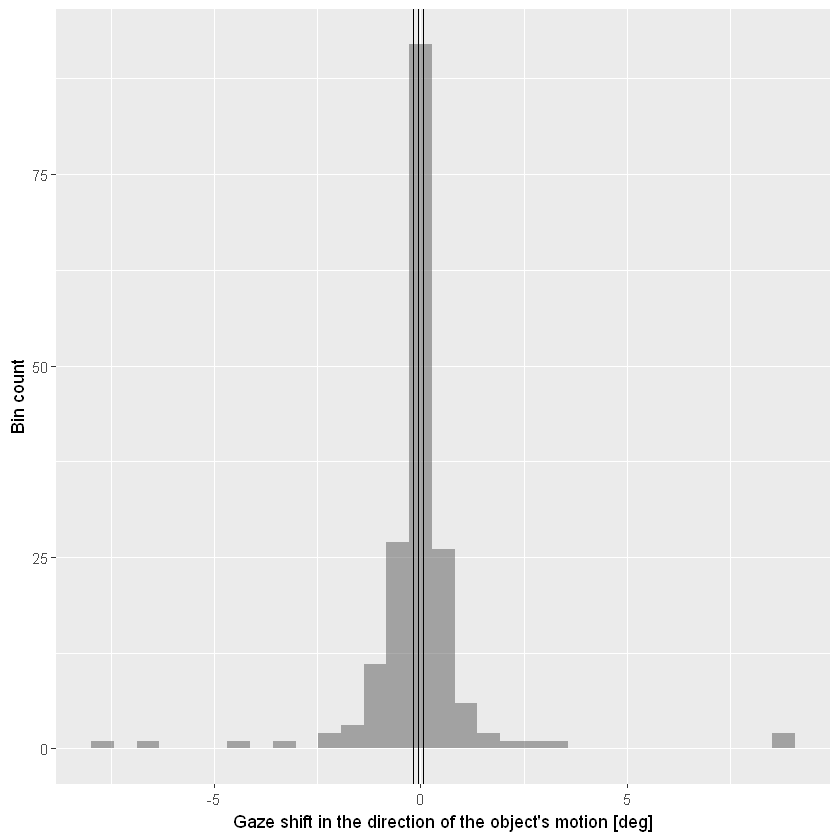

In [13]:
dx.test <- t.test(gaze.shift$dX)

deg.per.pixel= 0.0302 # for the screen and eye-screen distance as described in methods

mean.shift <- gaze.shift %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarise(shift= mean(dX * Direction * deg.per.pixel, na.rm= TRUE)) %>%
    dplyr::summarize(shift.mean= mean(shift), shift.sd= sd(shift)/sqrt(n()-1))

mean.shift

hist.plot <- ggplot(data= na.omit(gaze.shift), aes(x= dX * Direction * deg.per.pixel)) + 
    geom_histogram(bins= 31, alpha= 0.5) + 
    geom_vline(xintercept = mean.shift$shift.mean + c(-mean.shift$shift.sd, 0, mean.shift$shift.sd)) +
    xlab("Gaze shift in the direction of the object's motion [deg]") + 
    ylab('Bin count')
print(hist.plot)